In [59]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler

MERGED_DATA_DIR = "../../data/merged data"
OUTPUT_DIR = "../../output/assumption"

# Load the dataset
tnp_20 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2020", "merged_tnp_data.csv"))
tnp_19 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2019", "merged_tnp_data.csv"))

In [60]:
# 添加年份指示变量
tnp_20["is_2020"] = 1
tnp_19["is_2020"] = 0

scaler = StandardScaler()
cols_to_scale = ["daily_bus_rides", "rides"]
tnp_20[cols_to_scale] = scaler.fit_transform(tnp_20[cols_to_scale])
tnp_19[cols_to_scale] = scaler.fit_transform(tnp_19[cols_to_scale])

# 拼接数据
merged_df = pd.concat([tnp_20, tnp_19], ignore_index=True)
merged_df["price"] = merged_df["fare"] + merged_df["additional_charges"]

# 确保日期变量是 datetime 类型（后续 RDiT 会用到）
merged_df["trip_start_date"] = pd.to_datetime(merged_df["trip_start_date"])

# 创建工作日虚拟变量，drop_first=True 是为了避免虚拟变量陷阱
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='dow', drop_first=True)

# 合并到原始数据中
merged_df = pd.concat([merged_df, day_dummies], axis=1)

# 创建地区虚拟变量，drop_first=True 是为了避免虚拟变量陷阱
area_dummies = pd.get_dummies(merged_df['area_type'], prefix='at', drop_first=True)

# 合并到原始数据中
merged_df = pd.concat([merged_df, area_dummies], axis=1)

In [ ]:
def estimate_event_study_from_dif_in_rdit(
    df: pd.DataFrame,
    outcome: str,
    time_var: str,
    treat_year_var: str,
    cutoff_date,
    placebo_cutoff_date="2019-01-07",
    covariates: list = None,
    omit_week: int = -1  # 默认省略 event_week = -1 作为 baseline
):
    df = df.copy()
    df[time_var] = pd.to_datetime(df[time_var])
    cutoff_date = pd.to_datetime(cutoff_date)
    placebo_cutoff_date = pd.to_datetime(placebo_cutoff_date)

    # 1. 构建 days_from_cutoff
    df["cutoff_for_row"] = df[treat_year_var].apply(
        lambda x: cutoff_date if x == 1 else placebo_cutoff_date
    )
    df["days_from_cutoff"] = (df[time_var] - df["cutoff_for_row"]).dt.days

    # 3. 构建 event_week（周数）
    df["event_week"] = (df["days_from_cutoff"] // 7).astype(int)

    # 4. 平移，使 event_week_shift >= 0
    min_week = df["event_week"].min()
    df["event_week_shift"] = df["event_week"] - min_week

    # 5. 去除 baseline 周（如 event_week == -1）
    df = df[df["event_week"] != omit_week]

    # 6. 设置 RHS (右边变量)
    rhs = ["C(" + treat_year_var + ")", "C(event_week_shift)", "C(event_week_shift) * C(" + treat_year_var + ")"]
    if covariates:
        rhs += covariates

    # 7. 建立公式
    formula = f"{outcome} ~ " + " + ".join(rhs)

    # 8. 拟合 OLS
    model = smf.ols(formula=formula, data=df).fit(cov_type='HC3')

    # 9. 提取结果
    result_df = model.summary2().tables[1].copy()
    result_df.columns = result_df.columns.astype(str)
    result_df = result_df.rename(columns={
        "Coef.": "coef",
        "Std.Err.": "std_err",
        "P>|t|": "p_value",
        "[0.025": "ci_lower",
        "0.975]": "ci_upper"
    })
    result_df["variable"] = result_df.index
    result_df.reset_index(drop=True, inplace=True)

    # 10. 提取 event_week
    def parse_event_week(varname):
        if "C(event_week_shift)[T." in varname and ":" in varname:
            week_part = varname.split("[T.")[1].split("]")[0]
            try:
                week_shift = int(week_part)
                event_week = week_shift + min_week
                return event_week
            except:
                return np.nan
        return np.nan

    result_df["event_week"] = result_df["variable"].apply(parse_event_week)
    result_df = result_df.dropna(subset=["event_week"])

    return result_df


In [62]:
def plot_event_study(summary_df):
    # AEJ 风格设置
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10
    })

    fig, ax = plt.subplots(figsize=(6.5, 3.8))
    ax.axhline(0, color='black', linewidth=1.2, linestyle='--', zorder=1)

    ax.errorbar(
        summary_df["event_week"],
        summary_df["coef"],
        yerr=[
            summary_df["coef"] - summary_df["ci_lower"],
            summary_df["ci_upper"] - summary_df["coef"]
        ],
        fmt='o', capsize=3, markersize=4, color='black', zorder=2
    )

    ax.axvline(0, color='black', linestyle='--', linewidth=1, zorder=1)
    ax.set_title("Event Study Estimates of the Treatment Effect.", pad=10)
    ax.set_xlabel("Weeks from Cutoff")
    ax.set_ylabel("Treatment Effect")

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.1f}"))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
    plt.tight_layout()

    save_path = "../../output/assumption/event_study.pdf"

    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to: {save_path}")
    
    plt.show()


In [65]:
event_result = estimate_event_study_from_dif_in_rdit(
    df=merged_df,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    # covariates=[
    #     "trip_seconds", "trip_miles", "trip_during_peak",
    #     "Avg_Temp_C", "Precipitation_mm", "Snowfall_mm", "Avg_Wind_Speed_mps",
    #     "rides", "daily_bus_rides", "taxi",
    #     "dow_1", "dow_2", "dow_3", "dow_4",
    #     "at_1", "at_2"
    # ],
    omit_week=-2
)

Saved to: ../../output/assumption/event_study.pdf


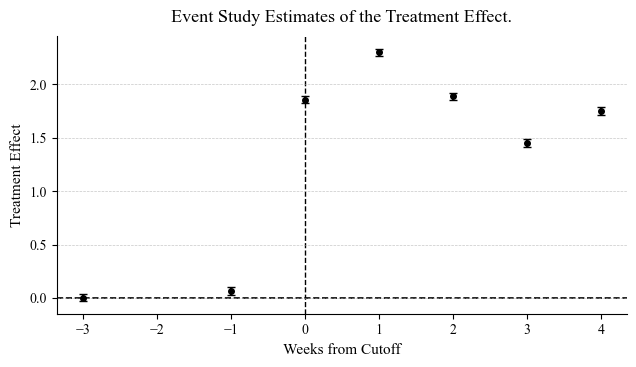

In [66]:
plot_event_study(event_result)